In [1]:
import pandas as pd
import numpy as np

In [45]:
train_data = pd.read_csv('train_data', sep=";")

In [46]:
train_data.select_dtypes(exclude=[object, bool]).columns

Index(['user_id', 'post_id', 'target', 'text_length', 'likes', 'posts_views',
       'likes_share', 'gender', 'age', 'business', 'covid', 'entertainment',
       'movie', 'politics', 'sport', 'tech', 'views', 'ratio of likes posts'],
      dtype='object')

In [47]:
numeric_columns = train_data.select_dtypes(exclude=[object, bool]).columns
numeric_columns = numeric_columns.drop(['target', 'gender', 'age'])
numeric_columns

Index(['user_id', 'post_id', 'text_length', 'likes', 'posts_views',
       'likes_share', 'business', 'covid', 'entertainment', 'movie',
       'politics', 'sport', 'tech', 'views', 'ratio of likes posts'],
      dtype='object')

In [55]:
categorical_columns = []

for col in train_data.columns:
    if col not in numeric_columns.tolist() and col not in ['target', 'gender', 'country', 'os', 'source', 'timestamp']:
        categorical_columns.append(col)

In [56]:
categorical_columns

['topic', 'age', 'city']

In [53]:
train_data = train_data.sort_values('timestamp')

In [60]:
train_data_update = train_data.drop(columns=['gender', 'country', 'os', 'source'])

In [61]:
train_data_update.head()

,user_id,post_id,target,timestamp,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts
1364185,91677,5385,1,2021-12-23 14:36:32,movie,432,702.0,6759.0,10.0,17,Moscow,0.0,0.0,0.0,0.250000,0.0,0.0,0.2,15,0.133333
4950977,161005,6782,0,2021-12-23 14:36:32,movie,2872,684.0,6633.0,10.0,15,Budënnovsk,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,15,0.000000
4580075,40293,6437,1,2021-12-23 14:36:32,movie,705,713.0,6834.0,10.0,15,Khabarovsk,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,15,0.133333
4642628,133794,3545,0,2021-12-23 14:36:32,covid,140,2591.0,16898.0,15.0,52,Dmitrovsk-Orlovskiy,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,15,0.000000
4904478,26676,3330,1,2021-12-23 14:36:32,covid,126,732.0,6832.0,10.0,20,Rostov,0.0,0.2,0.0,0.000000,0.0,0.0,0.0,15,0.066667


In [62]:
observations = train_data_update.shape[0]
first_class = train_data_update.query('target==1').shape[0]
first_class*100 / observations

13.825478205588833

In [63]:
from sklearn.model_selection import train_test_split

X = train_data_update.drop(columns=['target','timestamp'])
y = train_data_update['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    shuffle=False, #предварительно посортировали по дате
                                                    test_size=0.2)

X_train_clear = X_train.drop(columns=['user_id', 'post_id'])
X_test_clear = X_test.drop(columns=['user_id', 'post_id'])

In [64]:
from catboost import CatBoostClassifier
cat_boost = CatBoostClassifier(iterations=1000, verbose=100)

cat_boost.fit(X_train_clear, y_train, cat_features=categorical_columns)

Learning rate set to 0.355181
0:	learn: 0.4765016	total: 2.28s	remaining: 38m 1s
100:	learn: 0.2951376	total: 2m 50s	remaining: 25m 16s
200:	learn: 0.2885822	total: 5m 52s	remaining: 23m 19s
300:	learn: 0.2855086	total: 9m 24s	remaining: 21m 51s
400:	learn: 0.2839572	total: 12m 28s	remaining: 18m 37s
500:	learn: 0.2830001	total: 15m 29s	remaining: 15m 25s
600:	learn: 0.2823956	total: 18m 34s	remaining: 12m 19s
700:	learn: 0.2818252	total: 21m 41s	remaining: 9m 14s
800:	learn: 0.2810368	total: 24m 52s	remaining: 6m 10s
900:	learn: 0.2805887	total: 28m 4s	remaining: 3m 5s
999:	learn: 0.2801652	total: 31m 20s	remaining: 0us


In [74]:
cat_boost.save_model('catboost_model', format="cbm")

In [65]:
from sklearn.metrics import classification_report, f1_score, roc_curve, auc

predict_train = cat_boost.predict(X_train_clear)
predict_test = cat_boost.predict(X_test_clear)
f1_train = f1_score(y_train, predict_train)
f1_test = f1_score(y_test, predict_test)

print(f'F1 score на трейне {f1_train}, на тесте {f1_test}')

F1 score на трейне 0.17263784461152884, на тесте 0.2737507906388362


In [66]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score

predict_test = cat_boost.predict(X_test_clear)

recall = recall_score(y_test, predict_test)
precision = precision_score(y_test, predict_test)
roc_auc = roc_auc_score(y_test, predict_test)

print(f'recall = {recall}, precision = {precision}, roc_auc = {roc_auc}')

recall = 0.1761503995696398, precision = 0.613893137303271, roc_auc = 0.5789293642602725


In [77]:
prob = cat_boost.predict_proba(X_test_clear)

In [79]:
X_test_clear

,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts
3521651,movie,1572,679.0,6651.0,10.0,21,Krasnoselkup,0.0,0.066667,0.0,0.060000,0.000000,0.083333,0.2,113,0.061947
3718570,covid,140,1145.0,8372.0,13.0,19,Voronezh,0.2,0.206897,0.2,0.160000,0.375000,0.166667,0.5,113,0.203540
358576,business,1487,1103.0,8549.0,12.0,18,Saint Petersburg,0.0,0.040000,0.0,0.189189,0.153846,0.238095,0.2,113,0.141593
883155,covid,137,1658.0,17346.0,9.0,34,Novosibirsk,0.0,0.064516,0.0,0.076923,0.000000,0.000000,0.0,113,0.035398
841259,sport,2296,2879.0,22222.0,12.0,33,Krasnodar,0.0,0.041667,0.0,0.100000,0.000000,0.000000,0.0,113,0.035398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676345,sport,828,2757.0,22030.0,12.0,41,Saint Petersburg,0.0,0.666667,0.0,0.307692,0.000000,0.000000,1.0,36,0.250000
2553532,movie,4086,703.0,6843.0,10.0,15,Tyumen,0.0,0.250000,0.0,0.058824,0.000000,0.000000,0.0,36,0.083333
1136458,movie,1277,704.0,6730.0,10.0,15,Kamensk-Ural’skiy,0.0,0.250000,0.0,0.125000,0.250000,0.142857,0.0,36,0.166667
4613330,covid,140,718.0,6875.0,10.0,16,Asino,0.0,0.375000,0.0,0.000000,0.333333,0.333333,0.0,36,0.138889


In [68]:
X_test.head()

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts
3521651,130237,6430,movie,1572,679.0,6651.0,10.0,21,Krasnoselkup,0.0,0.066667,0.0,0.060000,0.000000,0.083333,0.2,113,0.061947
3718570,2702,2914,covid,140,1145.0,8372.0,13.0,19,Voronezh,0.2,0.206897,0.2,0.160000,0.375000,0.166667,0.5,113,0.203540
358576,101955,83,business,1487,1103.0,8549.0,12.0,18,Saint Petersburg,0.0,0.040000,0.0,0.189189,0.153846,0.238095,0.2,113,0.141593
883155,109837,2577,covid,137,1658.0,17346.0,9.0,34,Novosibirsk,0.0,0.064516,0.0,0.076923,0.000000,0.000000,0.0,113,0.035398
841259,9506,1720,sport,2296,2879.0,22222.0,12.0,33,Krasnodar,0.0,0.041667,0.0,0.100000,0.000000,0.000000,0.0,113,0.035398


In [69]:
first_class_prob = []
for row in range(X_test.shape[0]):
    first_class_prob.append(prob[row][1])

In [70]:
X_test['prob'] = first_class_prob
X_test['target'] = y_test

In [71]:
X_test.head()

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts,prob,target
3521651,130237,6430,movie,1572,679.0,6651.0,10.0,21,Krasnoselkup,0.0,0.066667,0.0,0.060000,0.000000,0.083333,0.2,113,0.061947,0.002619,0
3718570,2702,2914,covid,140,1145.0,8372.0,13.0,19,Voronezh,0.2,0.206897,0.2,0.160000,0.375000,0.166667,0.5,113,0.203540,0.184221,0
358576,101955,83,business,1487,1103.0,8549.0,12.0,18,Saint Petersburg,0.0,0.040000,0.0,0.189189,0.153846,0.238095,0.2,113,0.141593,0.000293,0
883155,109837,2577,covid,137,1658.0,17346.0,9.0,34,Novosibirsk,0.0,0.064516,0.0,0.076923,0.000000,0.000000,0.0,113,0.035398,0.006744,0
841259,9506,1720,sport,2296,2879.0,22222.0,12.0,33,Krasnodar,0.0,0.041667,0.0,0.100000,0.000000,0.000000,0.0,113,0.035398,0.000056,0


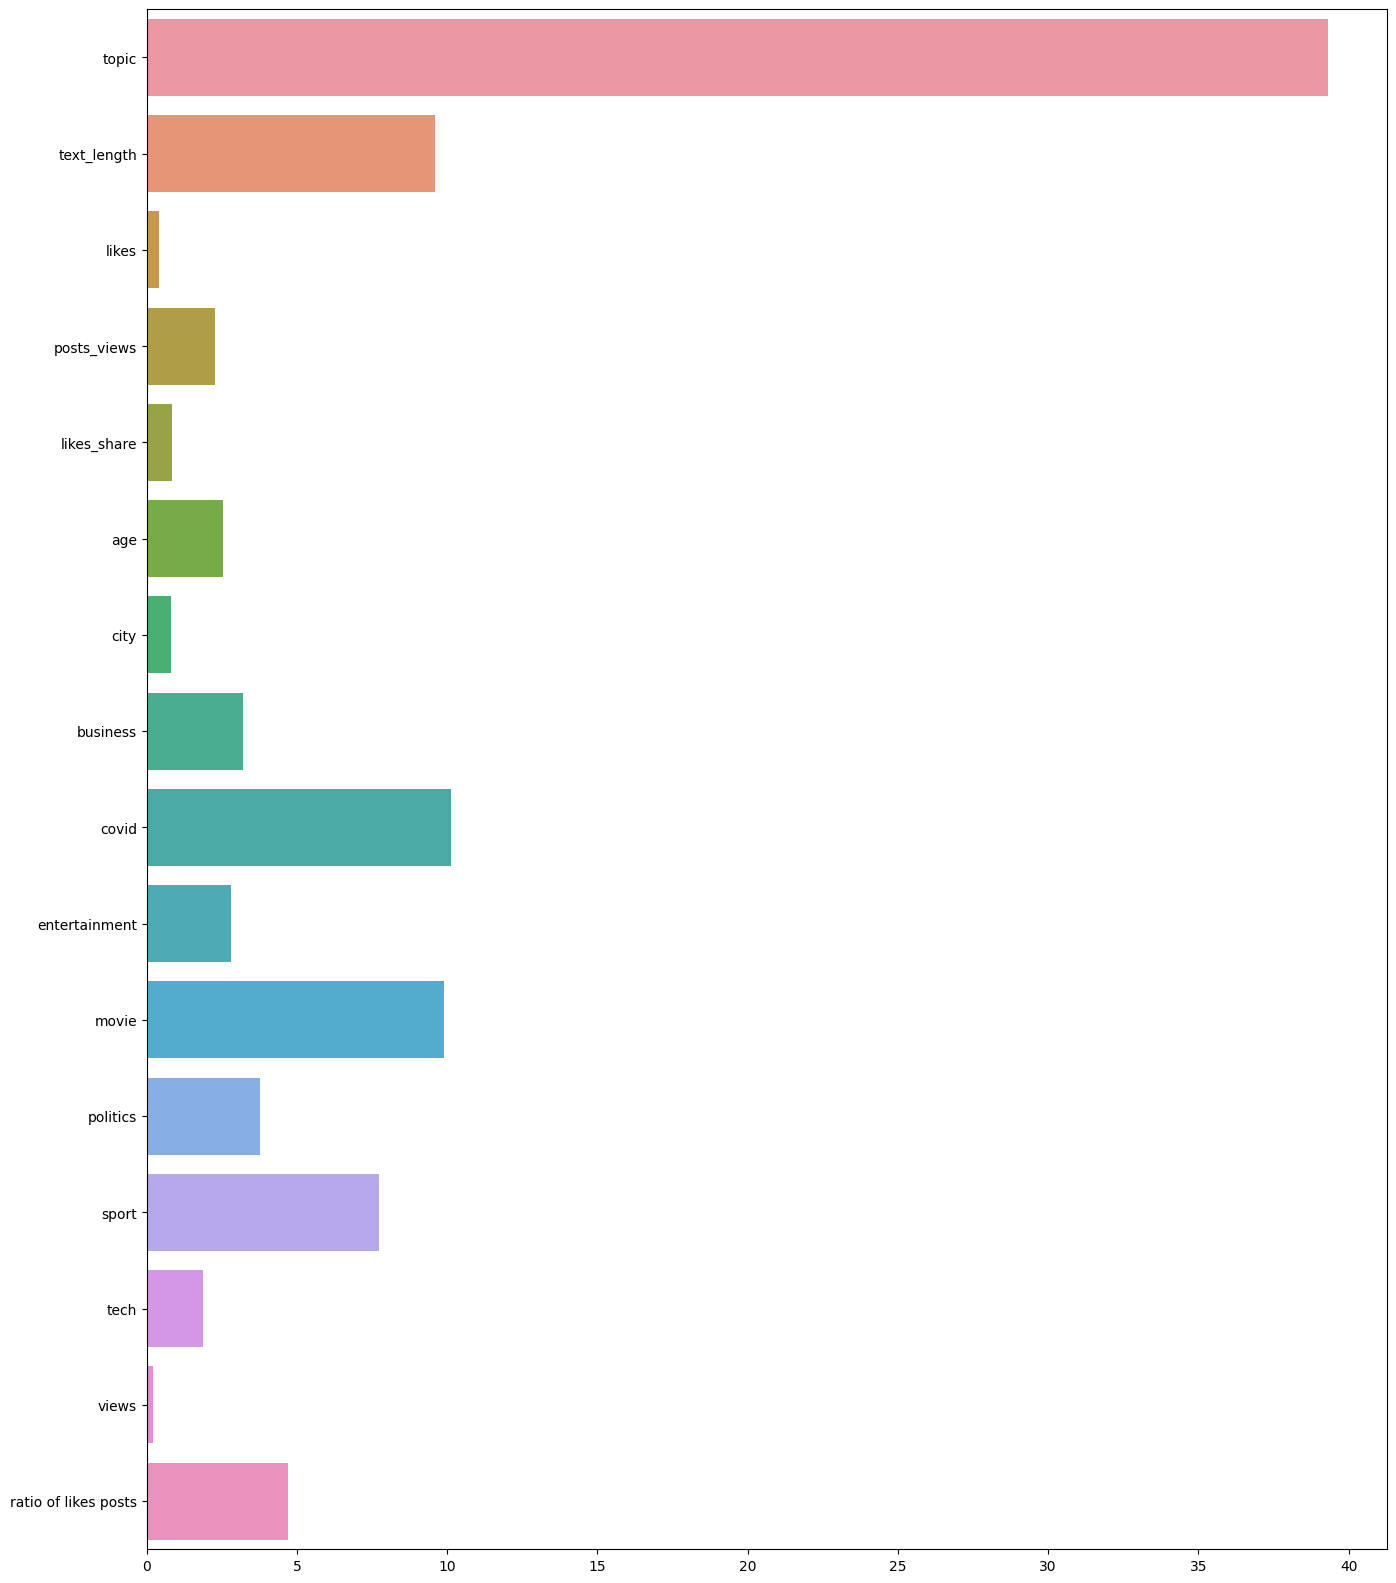

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()
fig.set_size_inches(16, 20)

sns.barplot(x=cat_boost.feature_importances_,
            y=X_test_clear.columns)


plt.show()

In [73]:
X_test.head()

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts,prob,target
3521651,130237,6430,movie,1572,679.0,6651.0,10.0,21,Krasnoselkup,0.0,0.066667,0.0,0.060000,0.000000,0.083333,0.2,113,0.061947,0.002619,0
3718570,2702,2914,covid,140,1145.0,8372.0,13.0,19,Voronezh,0.2,0.206897,0.2,0.160000,0.375000,0.166667,0.5,113,0.203540,0.184221,0
358576,101955,83,business,1487,1103.0,8549.0,12.0,18,Saint Petersburg,0.0,0.040000,0.0,0.189189,0.153846,0.238095,0.2,113,0.141593,0.000293,0
883155,109837,2577,covid,137,1658.0,17346.0,9.0,34,Novosibirsk,0.0,0.064516,0.0,0.076923,0.000000,0.000000,0.0,113,0.035398,0.006744,0
841259,9506,1720,sport,2296,2879.0,22222.0,12.0,33,Krasnodar,0.0,0.041667,0.0,0.100000,0.000000,0.000000,0.0,113,0.035398,0.000056,0


In [75]:
users_hitrate = []

for user in X_test['user_id'].unique():
    part = X_test[X_test['user_id']==user]
    part = part.sort_values('prob', ascending=False).head(5).reset_index()
    
    users_hitrate_ = []
    
    for i in part.target:
        if i == 1:
            users_hitrate_.append(1)
        else:
            users_hitrate_.append(0)
    
    users_hitrate_metric =  max(users_hitrate_)
    
    users_hitrate.append(users_hitrate_metric)
    
print(f"Среднее Hitrate@5 по пользователям из теста: {np.mean(users_hitrate)}")

Среднее Hitrate@5 по пользователям из теста: 0.8864073006724303


In [76]:
X_train

,user_id,post_id,topic,text_length,likes,posts_views,likes_share,age,city,business,covid,entertainment,movie,politics,sport,tech,views,ratio of likes posts
1364185,91677,5385,movie,432,702.0,6759.0,10.0,17,Moscow,0.0,0.000000,0.000000,0.250000,0.000000,0.000000,0.200000,15,0.133333
4950977,161005,6782,movie,2872,684.0,6633.0,10.0,15,Budënnovsk,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,0.000000
4580075,40293,6437,movie,705,713.0,6834.0,10.0,15,Khabarovsk,0.0,0.000000,0.000000,0.222222,0.000000,0.000000,0.000000,15,0.133333
4642628,133794,3545,covid,140,2591.0,16898.0,15.0,52,Dmitrovsk-Orlovskiy,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15,0.000000
4904478,26676,3330,covid,126,732.0,6832.0,10.0,20,Rostov,0.0,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,15,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030088,60627,877,entertainment,2421,741.0,6645.0,11.0,17,Vladivostok,0.0,0.129032,0.111111,0.170732,0.083333,0.066667,0.250000,113,0.132743
981776,157447,5846,movie,1608,704.0,6663.0,10.0,26,Kuybyshev,0.5,0.111111,0.500000,0.153846,0.300000,0.285714,0.285714,113,0.203540
1835720,16314,6804,movie,538,648.0,6531.0,9.0,24,Saint Petersburg,0.2,0.260870,0.000000,0.153846,0.250000,0.333333,0.333333,113,0.203540
156034,53801,1876,sport,2097,2840.0,22411.0,12.0,33,Yaroslavl,0.0,0.050000,0.000000,0.115385,0.000000,0.000000,0.000000,113,0.035398
